In [ ]:
import logging
from tqdm.notebook import tqdm

import tensorflow as tf

from ssd.common.viz_utils import draw_boxes_cv2, imshow, imshow_multiple
from ssd.common.box_utils import rescale_boxes

logger = tf.get_logger()
logger.setLevel(logging.INFO)

logger.info('version: {}'.format(tf.__version__))

In [2]:
def _parse_example(example_proto, _input_height=448, _input_width=448):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'xmins': tf.io.VarLenFeature(tf.float32),
        'ymins': tf.io.VarLenFeature(tf.float32),
        'xmaxs': tf.io.VarLenFeature(tf.float32),
        'ymaxs': tf.io.VarLenFeature(tf.float32),
        'classes': tf.io.VarLenFeature(tf.int64),
    }

    parsed_example = tf.io.parse_single_example(example_proto,
                                                feature_description)
    classes = tf.sparse.to_dense(parsed_example['classes'])

    image = tf.io.decode_image(parsed_example['image'], channels=3)
    image = tf.cast(image, dtype=tf.float32)
    image.set_shape([None, None, 3])
    original_dims = tf.shape(image)
    image = tf.image.resize(image,
                            size=[_input_height, _input_width])

    boxes = tf.stack([
        tf.sparse.to_dense(parsed_example['xmins']),
        tf.sparse.to_dense(parsed_example['ymins']),
        tf.sparse.to_dense(parsed_example['xmaxs']),
        tf.sparse.to_dense(parsed_example['ymaxs']),
    ], axis=-1)
    boxes = rescale_boxes(boxes,
                          [original_dims[0], original_dims[1]],
                          [_input_height, _input_width])
    return image, boxes, classes

def relative_to_absolute(boxes, image_dims):
    boxes = tf.cast(boxes, dtype=tf.float32)
    image_dims = tf.cast(image_dims, dtype=tf.float32)
    return tf.stack([
        boxes[..., 0] * image_dims[1],
        boxes[..., 1] * image_dims[0],
        boxes[..., 2] * image_dims[1],
        boxes[..., 3] * image_dims[0]
    ], axis=-1)

def absolute_to_relative(boxes, image_dims):
    boxes = tf.cast(boxes, dtype=tf.float32)
    image_dims = tf.cast(image_dims, dtype=tf.float32)
    return tf.stack([
        boxes[..., 0] / image_dims[1],
        boxes[..., 1] / image_dims[0],
        boxes[..., 2] / image_dims[1],
        boxes[..., 3] / image_dims[0]
    ], axis=-1)

In [19]:
_tfrecords = tf.data.Dataset.list_files('ssd/data/dataset_files/coco/train*')
dataset = _tfrecords.interleave(
    tf.data.TFRecordDataset,
    cycle_length=8,
    block_length=32,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(512)
dataset = dataset.map(_parse_example,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [4]:
def swap_xy(boxes):
    boxes = tf.cast(boxes, dtype=tf.float32)
    return tf.stack([
        boxes[:, 1],
        boxes[:, 0],
        boxes[:, 3],
        boxes[:, 2],
    ], axis=-1)

def relative_to_absolute(boxes, image_dims):
    boxes = tf.cast(boxes, dtype=tf.float32)
    image_dims = tf.cast(image_dims, dtype=tf.float32)
    return tf.stack([
        boxes[..., 0] * image_dims[1],
        boxes[..., 1] * image_dims[0],
        boxes[..., 2] * image_dims[1],
        boxes[..., 3] * image_dims[0]
    ], axis=-1)

def absolute_to_relative(boxes, image_dims):
    boxes = tf.cast(boxes, dtype=tf.float32)
    image_dims = tf.cast(image_dims, dtype=tf.float32)
    return tf.stack([
        boxes[..., 0] / image_dims[1],
        boxes[..., 1] / image_dims[0],
        boxes[..., 2] / image_dims[1],
        boxes[..., 3] / image_dims[0]
    ], axis=-1)

In [84]:
def filter_and_adjust_labels(crop_box, boxes, classes):
    boxes = tf.cast(boxes, dtype=tf.float32)
    crop_box = tf.cast(crop_box, dtype=tf.float32)
    
    offsets = tf.concat([
        crop_box[:, :2] - boxes[:, 2:], 
        boxes[:, :2] - crop_box[:, 2:],
    ], axis=-1)
    
    crop_box_width = crop_box[:, 2] - crop_box[:, 0]
    crop_box_height = crop_box[:, 3] - crop_box[:, 1]
    
    adjusted_boxes = tf.stack([
        tf.clip_by_value(boxes[:, 0] - crop_box[:, 0], 0, crop_box_width),
        tf.clip_by_value(boxes[:, 1] - crop_box[:, 1], 0, crop_box_height),
        tf.clip_by_value(boxes[:, 2] - crop_box[:, 0], 0, crop_box_width),
        tf.clip_by_value(boxes[:, 3] - crop_box[:, 1], 0, crop_box_height)
    ], axis=-1)

    idx = tf.where(tf.logical_not(tf.reduce_all(offsets >= 0, axis=-1)))
    if tf.gather(adjusted_boxes, idx[:, 0]).shape[0] == 0:
        print(crop_box, boxes, offsets)
    return tf.gather(adjusted_boxes, idx[:, 0]), tf.gather(classes, idx[:, 0])

def _random_crop(image, boxes, classes):
    min_obj_covered = 0.1
    area_range = [0.05, 1]
    aspect_ratio_range = [0.667, 1.334]

    boxes = absolute_to_relative(boxes, tf.shape(image))

    start, size, crop_box = tf.python.image.sample_distorted_bounding_box_v2(
        image_size=tf.shape(image),
        bounding_boxes=tf.expand_dims(swap_xy(boxes), axis=0),
        min_object_covered=min_obj_covered,
        area_range=area_range,
        aspect_ratio_range=aspect_ratio_range)
    
    crop_box = relative_to_absolute(swap_xy(crop_box[0]), tf.shape(image))

    cropped_image = tf.slice(image, start, size)
    cropped_image.set_shape([None, None, 3])

    boxes = relative_to_absolute(boxes, tf.shape(image))
    adjusted_boxes, adjusted_classes = filter_and_adjust_labels(crop_box, boxes, classes)

    return cropped_image, adjusted_boxes, adjusted_classes

In [85]:
for image, boxes, cls_ids in tqdm(dataset):
    h, w, _ = image.shape
    boxes = tf.stack([
        tf.clip_by_value(boxes[:, 0], 0, w),
        tf.clip_by_value(boxes[:, 1], 0, h),
        tf.clip_by_value(boxes[:, 2], 0, w),
        tf.clip_by_value(boxes[:, 3], 0, h),
    ], axis=-1)
    img, bx, cx = _random_crop(image, boxes, cls_ids)
    if bx.shape[0] == 0:
        print(bx)
        break

KeyboardInterrupt: 

<tf.Tensor: shape=(0, 4), dtype=float32, numpy=array([], shape=(0, 4), dtype=float32)>

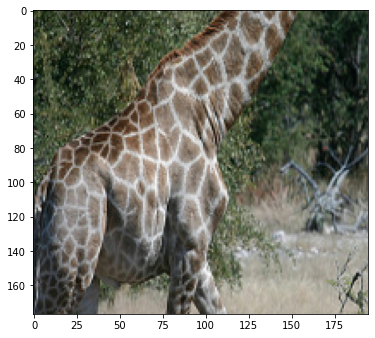

In [22]:
imshow(img/255)

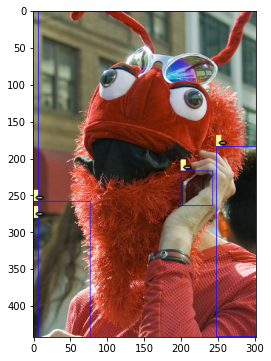

In [132]:
img, bx, cx = _random_crop(image, boxes, cls_ids)
imshow(draw_boxes_cv2(img, bx, list('_' * len(cx))))

In [123]:
boxes

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[2.7093134e+02, 2.1723099e+02, 3.1311624e+02, 2.6453699e+02],
       [7.7064415e+01, 3.2200000e-01, 4.3240063e+02, 4.4800000e+02],
       [0.0000000e+00, 2.8020300e+02, 6.1135521e+01, 4.4800000e+02],
       [3.1862686e+02, 1.8423300e+02, 4.4800000e+02, 4.4195898e+02],
       [6.5776779e+01, 2.5895801e+02, 1.4748244e+02, 4.4800000e+02]],
      dtype=float32)>